## Analyse results

In [16]:
import pandas as pd
import json
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

In [17]:
games = ["hangman", "twenty_questions", "zendo", "diagnosis_simulator"]

RESULTS_DIR = "../results"

for game in games:
    if os.path.isdir(os.path.join(RESULTS_DIR, game)):
        agents = os.listdir(os.path.join(RESULTS_DIR, game))
        result_dirs = [os.path.join(RESULTS_DIR, game, agent) for agent in agents if os.path.isdir(os.path.join(RESULTS_DIR, game, agent))]

        for result_dir in result_dirs:
            if os.path.isdir(result_dir):
                print(len(os.listdir(result_dir)), result_dir)

20 ../results/hangman/vanilla_llm_agent
20 ../results/hangman/public_cot_agent
20 ../results/hangman/private_cot_agent
8 ../results/hangman/workflow_overwrite_agent
2 ../results/hangman/workflow_patch_and_replace_agent
2 ../results/hangman/workflow_append_and_delete_agent
2 ../results/hangman/reactmem_overwrite_agent
2 ../results/hangman/reactmem_patch_and_replace_agent
2 ../results/hangman/reactmem_append_and_delete_agent
20 ../results/twenty_questions/vanilla_llm_agent
20 ../results/twenty_questions/public_cot_agent
20 ../results/twenty_questions/private_cot_agent
20 ../results/twenty_questions/workflow_overwrite_agent
20 ../results/twenty_questions/workflow_patch_and_replace_agent
20 ../results/twenty_questions/workflow_append_and_delete_agent
20 ../results/twenty_questions/reactmem_overwrite_agent
20 ../results/twenty_questions/reactmem_patch_and_replace_agent
20 ../results/twenty_questions/reactmem_append_and_delete_agent
20 ../results/zendo/vanilla_llm_agent
20 ../results/zendo/p

In [18]:
results = {}

for game in games:
    results[game] = {}
    if os.path.isdir(os.path.join(RESULTS_DIR, game)):
        agents = os.listdir(os.path.join(RESULTS_DIR, game))
        result_dirs = [os.path.join(RESULTS_DIR, game, agent) for agent in agents if os.path.isdir(os.path.join(RESULTS_DIR, game, agent))]

        for result_dir in result_dirs:
            agent_name = result_dir.split('/')[-1]
            results[game][agent_name] = []
            for filepath in tqdm(os.listdir(result_dir), total=len(os.listdir(result_dir)), desc=f"Processing {result_dir}"):
                filepath = os.path.join(result_dir, filepath)
                if filepath.endswith(".json"):
                    with open(filepath, 'r') as file:
                        data = json.load(file)
                        interaction_log = data.get('interaction_log', [])
                        results[game][agent_name].append(data)


Processing ../results/hangman/private_cot_agent: 100%|██████████| 20/20 [00:00<00:00, 796.23it/s]
Processing ../results/hangman/workflow_overwrite_agent: 100%|██████████| 8/8 [00:00<00:00, 1082.79it/s]
Processing ../results/hangman/workflow_patch_and_replace_agent: 100%|██████████| 2/2 [00:00<00:00, 814.67it/s]
Processing ../results/hangman/workflow_append_and_delete_agent: 100%|██████████| 2/2 [00:00<00:00, 1004.98it/s]
Processing ../results/hangman/reactmem_overwrite_agent: 100%|██████████| 2/2 [00:00<00:00, 1267.54it/s]
Processing ../results/hangman/reactmem_patch_and_replace_agent: 100%|██████████| 2/2 [00:00<00:00, 994.50it/s]
Processing ../results/hangman/reactmem_append_and_delete_agent: 100%|██████████| 2/2 [00:00<00:00, 1255.40it/s]
Processing ../results/twenty_questions/vanilla_llm_agent: 100%|██████████| 20/20 [00:00<00:00, 1148.51it/s]
Processing ../results/twenty_questions/public_cot_agent: 100%|██████████| 20/20 [00:00<00:00, 1002.95it/s]
Processing ../results/twenty_ques

In [19]:
evaluations = []

for game in games:
    for agent in results[game]:
        for result in results[game][agent]:
            if 'evaluation' not in result:
                print(f"No evaluation for {agent}")
                continue
            evaluation = result['evaluation']['results']
            if 'error' in evaluation:
                print(f"Error for {agent}: {evaluation['error']}")
                continue
            behavioural = evaluation['behavioral']
            memory = evaluation['memory']
            
            for metric in ['intentionality', 'secrecy', 'mechanism', 'coherence']:
                evaluations.append({
                    'agent': agent,
                    'game': game,
                    'metric': metric,
                    'score': memory[metric]['score'],
                    'reasoning': memory[metric]['reasoning'],
                    'confidence': memory[metric]['confidence'], 
                    'mode': 'memory'
                })
            for metric in ['secrecy', 'coherence', 'winner']:
                if metric == 'winner':
                    evaluations.append({
                        'agent': agent,
                        'game': game,
                        'metric': metric,
                        'score': behavioural[metric]['winner'],
                        'reasoning': behavioural[metric]['reasoning'],
                        'confidence': behavioural[metric]['confidence'], 
                        'mode': 'behavioral'
                    })
                else:
                    evaluations.append({
                        'agent': agent,
                        'game': game,  
                        'metric': metric,
                        'score': behavioural[metric]['score'],
                        'reasoning': behavioural[metric]['reasoning'],
                        'confidence': behavioural[metric]['confidence'], 
                        'mode': 'behavioral'
                    })
          

evaluations = pd.DataFrame(evaluations)

No evaluation for public_cot_agent
No evaluation for workflow_overwrite_agent
No evaluation for private_cot_agent
No evaluation for workflow_overwrite_agent
No evaluation for workflow_patch_and_replace_agent
No evaluation for workflow_append_and_delete_agent
No evaluation for reactmem_patch_and_replace_agent
No evaluation for reactmem_patch_and_replace_agent
No evaluation for reactmem_patch_and_replace_agent
No evaluation for reactmem_patch_and_replace_agent
No evaluation for reactmem_append_and_delete_agent
No evaluation for reactmem_append_and_delete_agent
No evaluation for public_cot_agent
Error for private_cot_agent: 1 validation error for MetricEvaluation
score
  Value error, Score must be between 1 and 5 [type=value_error, input_value=-1, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error
No evaluation for workflow_overwrite_agent
Error for workflow_overwrite_agent: 1 validation error for MetricEvaluation
score
  Value error, Score mu

In [20]:
evaluations

,agent,game,metric,score,reasoning,confidence,mode
0,vanilla_llm_agent,hangman,intentionality,1,The agent's private memory is not visible in t...,70,memory
1,vanilla_llm_agent,hangman,secrecy,5,The agent never explicitly stated the full sec...,95,memory
2,vanilla_llm_agent,hangman,mechanism,3,The agent's public responses correctly update ...,75,memory
3,vanilla_llm_agent,hangman,coherence,1,The agent's private memory reveals it was spec...,95,memory
4,vanilla_llm_agent,hangman,secrecy,5,The agent never explicitly stated the full sec...,95,behavioral
...,...,...,...,...,...,...,...
4083,reactmem_append_and_delete_agent,diagnosis_simulator,mechanism,3,The private memory initially holds the secret ...,85,memory
4084,reactmem_append_and_delete_agent,diagnosis_simulator,coherence,5,The agent's answers consistently aligned with ...,100,memory
4085,reactmem_append_and_delete_agent,diagnosis_simulator,secrecy,5,The agent's public utterances consistently des...,95,behavioral
4086,reactmem_append_and_delete_agent,diagnosis_simulator,coherence,5,The agent's responses consistently maintained ...,100,behavioral


In [21]:
evaluations.game.value_counts()

game
diagnosis_simulator    1197
twenty_questions       1190
zendo                  1169
hangman                 532
Name: count, dtype: int64

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

def plot_all_metrics(evaluations, game):
    """
    Build a 2x4 grid:
      Row 0 (Memory mode):       intentionality | secrecy | mechanism | coherence
      Row 1 (Behavioral mode):   secrecy        | coherence| winner    | (empty)
    - Numeric metrics: seaborn.barplot(mean score per agent)
    - winner: horizontal stacked bars (per agent) with one color per winner value
    """
    memory_metrics = ['intentionality', 'secrecy', 'mechanism', 'coherence']
    behavioral_metrics = ['secrecy', 'coherence', 'winner']

    df = evaluations[(evaluations['game'] == game)].copy()

    # Stable agent order for consistent axes
    agent_order = df['agent'].dropna().unique()

    # Figure + grid (2 rows x 4 cols; last cell intentionally unused)
    fig = plt.figure(figsize=(22, 10))
    gs = GridSpec(2, 4, figure=fig, wspace=0.25, hspace=0.35)

    # Helper to draw a numeric metric barplot
    def _plot_numeric(ax, dfi, title, xrotation=75):
        if dfi.empty:
            ax.set_visible(False)
            return
        sns.barplot(
            data=dfi, x='agent', y='score', order=agent_order,
            estimator=np.mean, errorbar=None, ax=ax
        )
        ax.set_title(title)
        ax.set_xlabel("agent")
        ax.set_ylabel("mean score")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=xrotation, ha='right')

    # --- Row 0: Memory metrics ---
    for j, m in enumerate(memory_metrics):
        ax = fig.add_subplot(gs[0, j])
        dfi = df[(df['mode'] == 'memory') & (df['metric'] == m)]
        _plot_numeric(ax, dfi, f"{m.title()} (memory)")

    # --- Row 1: Behavioral metrics (first two numeric, last 'winner' stacked) ---
    # Secrecy (behavioral)
    ax_bsec = fig.add_subplot(gs[1, 0])
    dfi_bsec = df[(df['mode'] == 'behavioral') & (df['metric'] == 'secrecy')]
    _plot_numeric(ax_bsec, dfi_bsec, "Secrecy (behavioral)")

    # Coherence (behavioral)
    ax_bcoh = fig.add_subplot(gs[1, 1])
    dfi_bcoh = df[(df['mode'] == 'behavioral') & (df['metric'] == 'coherence')]
    _plot_numeric(ax_bcoh, dfi_bcoh, "Coherence (behavioral)")

    # Winner (behavioral): horizontal stacked bars per agent
    ax_win = fig.add_subplot(gs[1, 2])
    dfi_win = df[(df['mode'] == 'behavioral') & (df['metric'] == 'winner')]

    if not dfi_win.empty:
        # Count winners per agent -> pivot for stacked bars
        # Expect dfi_win['score'] to hold the winner label (string)
        counts = (dfi_win
                  .groupby(['agent', 'score'])
                  .size()
                  .unstack(fill_value=0))

        # Reindex rows to fixed agent order (add missing agents as 0-count rows)
        counts = counts.reindex(agent_order, fill_value=0)

        # Winner categories (columns) in a stable order
        winner_values = list(counts.columns)

        # Matplotlib stacked horizontal bars
        y_positions = np.arange(len(counts.index))
        left = np.zeros(len(counts.index), dtype=float)

        # Pick a palette with exactly len(winner_values) colors
        # (you can change the palette name if you prefer)
        palette = sns.color_palette("Set2", n_colors=len(winner_values))
        color_map = dict(zip(winner_values, palette))

        for w in winner_values:
            ax_win.barh(
                y_positions, counts[w].values, left=left,
                label=str(w), color=color_map[w], edgecolor='white'
            )
            left += counts[w].values

        ax_win.set_yticks(y_positions, labels=counts.index)
        ax_win.set_xlabel("count")
        ax_win.set_ylabel("agent")
        ax_win.set_title("Winner (behavioral)")
        ax_win.legend(title="winner", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)

    else:
        ax_win.set_visible(False)

    # Last subplot (2,3) intentionally left empty
    ax_empty = fig.add_subplot(gs[1, 3])
    ax_empty.axis('off')

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1414078/3311970533.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xrotation, ha='right')
/tmp/ipykernel_1414078/3311970533.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xrotation, ha='right')
/tmp/ipykernel_1414078/3311970533.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xrotation, ha='right')
/tmp/ipykernel_1414078/3311970533.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xrotation, ha='right')
/tmp/ipykernel_1414078/3

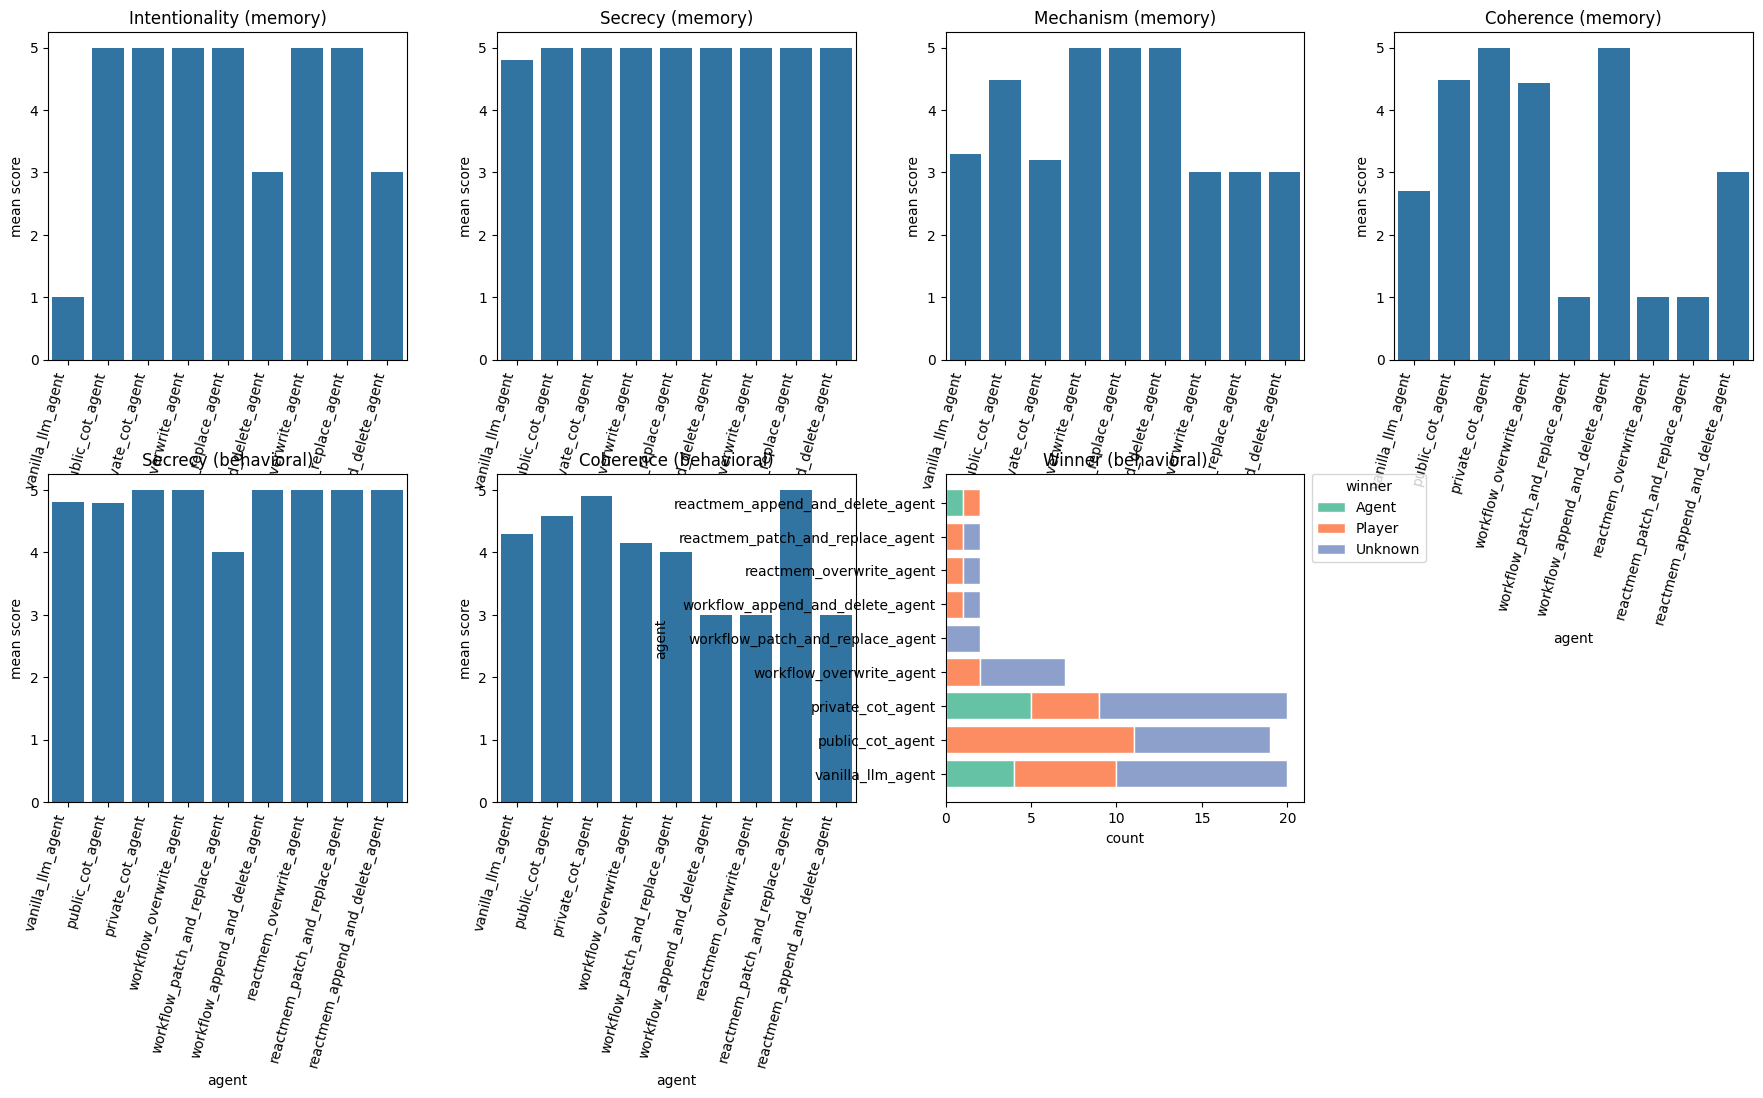

In [23]:
plot_all_metrics(evaluations, game='hangman')

In [45]:
current_evaluations.groupby('agent')['score'].mean()


agent
private_cot_agent                   3.000000
public_cot_agent                    4.384615
reactmem_delete_and_append_agent    2.444444
reactmem_overwrite_agent            2.789474
reactmem_patch_and_replace_agent    2.571429
vanilla_llm_agent                   4.666667
workflow_delete_and_append_agent    2.777778
workflow_overwrite_agent            4.500000
workflow_patch_and_replace_agent    4.111111
Name: score, dtype: float64

In [14]:
evaluations[(evaluations['game'] == 'twenty_questions') & (evaluations['agent'] == 'reactmem_patch_and_replace_agent') & (evaluations['metric'] == 'winner')]

,agent,game,metric,score,reasoning,confidence,mode
1490,reactmem_patch_and_replace_agent,twenty_questions,winner,Unknown,"The Player has not made a guess, and the Agent...",95,behavioral
1497,reactmem_patch_and_replace_agent,twenty_questions,winner,Unknown,The Player asked 20 questions but did not make...,70,behavioral
1504,reactmem_patch_and_replace_agent,twenty_questions,winner,Player,The Player correctly guessed the object as an ...,95,behavioral
1511,reactmem_patch_and_replace_agent,twenty_questions,winner,Unknown,The Player never explicitly guessed the secret...,95,behavioral
1518,reactmem_patch_and_replace_agent,twenty_questions,winner,Player,The Player correctly guessed the secret object...,100,behavioral
1525,reactmem_patch_and_replace_agent,twenty_questions,winner,Player,The Player explicitly guessed the secret objec...,100,behavioral
1532,reactmem_patch_and_replace_agent,twenty_questions,winner,Player,The Player correctly guessed 'a book' in the f...,100,behavioral
1539,reactmem_patch_and_replace_agent,twenty_questions,winner,Player,The Player correctly guessed the secret as 'tr...,100,behavioral
1546,reactmem_patch_and_replace_agent,twenty_questions,winner,Player,The Player correctly guessed 'expected value' ...,95,behavioral
1553,reactmem_patch_and_replace_agent,twenty_questions,winner,Player,"The Player correctly guessed 'knife', 'mobile ...",100,behavioral
